In [1]:
pip install pandas scikit-learn matplotlib joblib


In [2]:
import urllib.request, zipfile
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
urllib.request.urlretrieve(url, 'bank.zip')
with zipfile.ZipFile('bank.zip','r') as z:
    z.extractall()

df = pd.read_csv('bank-full.csv', sep=';')   # file extracted from zip


In [3]:
print(df.shape)
print(df.columns)
print(df.head())
print(df['y'].value_counts(normalize=True))  # target distribution
print(df.isnull().sum())  # check missing values (there shouldn't be any)


(45211, 17)
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92    

In [4]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})

numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = [c for c in df.columns if c not in numeric_features + ['y']]


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])


In [9]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))


Accuracy: 0.8745991374543846
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7985
           1       0.46      0.48      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.88      0.87      0.88      9043

ROC AUC: 0.7014571863832587
Confusion matrix:
 [[7406  579]
 [ 555  503]]


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 7, 10, None],
    'clf__min_samples_leaf': [1, 5, 10, 20]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
best_model = grid.best_estimator_

# Evaluate best on test
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:,1]
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred_best))
print('ROC AUC:', roc_auc_score(y_test, y_proba_best))


Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 20}
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7985
           1       0.58      0.45      0.51      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.71      0.73      9043
weighted avg       0.89      0.90      0.89      9043

ROC AUC: 0.88563593363265


duration              0.393857
poutcome_success      0.189818
age                   0.055994
day                   0.054050
pdays                 0.047909
balance               0.041525
housing_yes           0.040684
month_mar             0.027708
month_jun             0.019066
month_apr             0.017212
contact_unknown       0.016117
month_oct             0.014652
campaign              0.013094
month_may             0.009374
month_feb             0.008480
month_sep             0.005602
marital_married       0.005197
contact_cellular      0.004422
month_aug             0.004153
education_tertiary    0.004086
dtype: float64


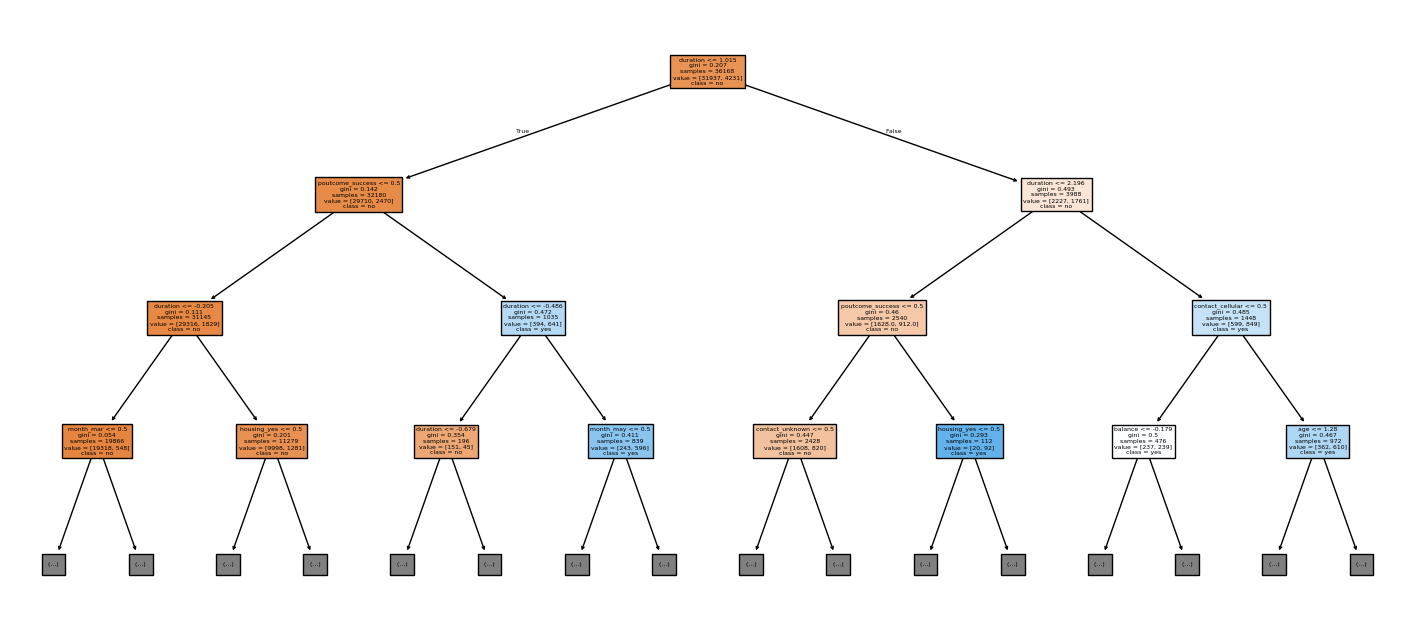

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# get feature names produced by preprocessor
ohe = best_model.named_steps['preproc'].named_transformers_['cat']
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_feature_names

importances = best_model.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
print(feat_imp)

# visualize first 3 levels of tree
plt.figure(figsize=(18,8))
plot_tree(best_model.named_steps['clf'], feature_names=feature_names, class_names=['no','yes'], filled=True, max_depth=3)
plt.show()


In [13]:
import joblib
joblib.dump(best_model, 'bank_decision_tree.pkl')
# load with: model = joblib.load('bank_decision_tree.pkl')


['bank_decision_tree.pkl']